In [1]:
import h5py
import numpy as np
import numpy.ma as ma
import scipy
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d
import glob
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors
from astropy.stats import LombScargle
import datetime
from datetime import date

Varible Definitions:

In [2]:
def defining_variables(ISRdata):
    
    """
    Defines the varibles needed for each h5 file.
    
    Used in the Ne_function and the rel_e_den_array_function.
    """
    
    all_electron_density = np.array(ISRdata['NeFromPower/Ne_NoTr'])
    #electron_density = all_electron_density[0,:,0]
    
    all_altitude = np.array(ISRdata['NeFromPower/Altitude'])
    altitude_slice = np.array(all_altitude[0,:])
    altitude_slice_km = altitude_slice/1000.
    lower_limit = 100.
    upper_limit = 500.
    altitude_0 = np.array(all_altitude[0,36:126])
    altitude_0_km = altitude_0 / 1000
    
    all_time = np.array(ISRdata['Time/UnixTime'])
    #average_time = np.mean(all_time, axis = 1)
    time_slice_seconds = np.array(all_time[:,0])
    time_slice = time_slice_seconds/3600.
    
    inital_time = time_slice_seconds[0]
    year_month_day = date.fromtimestamp(inital_time)
    #date = str(ISRdata)[12:20]
    
    return all_electron_density, altitude_slice_km, time_slice, lower_limit, upper_limit, altitude_0_km, year_month_day

In [3]:
def altitude_limits(altitude_no_bounds,lower_limit,upper_limit,e_density):
    
    min_val_low = np.abs(altitude_no_bounds[0]-lower_limit)
    min_val_up = np.abs(altitude_no_bounds[0]-upper_limit)
    
    for i in range(len(altitude_no_bounds)):
        """
        Returns the indeces for the lower and upper limits of altitude.
        """
        diff_low = np.abs(altitude_no_bounds[i]-lower_limit)
        if diff_low < min_val_low:
            min_val_low = diff_low
            lower_ind = i
            
        diff_up = np.abs(altitude_no_bounds[i]-upper_limit)
        if diff_up < min_val_up:
            min_val_up = diff_up
            upper_ind = i
    upper_ind = upper_ind + 1   
    altitude = altitude_no_bounds[lower_ind:upper_ind]
    e_density = e_density[:,:,lower_ind:upper_ind]
    return altitude,e_density

Electron Density (time, altitude) :

In [4]:
def Ne_function(e_density, altitude, time, year_month_day):
    
    """
    Generates a plot of Ne as a function of altitude and time.
    
    Enter the h5 file names.
    """

    figure_size = ['','']
    figure_size[0] = 14
    figure_size[1] = 4
    plt.rcParams["figure.figsize"] = figure_size

    time = time - time[0]
    
    ymin, ymax = altitude[0], altitude[-1]
    y = np.linspace(ymin, ymax, e_density.shape[2])

    xmin, xmax = time[0], time[-1]
    x = np.linspace(xmin, xmax, e_density.shape[0])

    Y,X = np.meshgrid(y,x)

    Z = np.array(e_density[:,0,:])

    fig, ax = plt.subplots()
    im = ax.pcolormesh(X,Y,Z, norm = colors.LogNorm(vmin = 10**9.5, vmax = 10**11.5), cmap = plt.get_cmap('jet'))
    ax.tick_params(axis = 'y',right=True, labelright=False, direction='in')
    cbar = fig.colorbar(im, orientation = 'vertical', pad = .01)
    cbar.set_label('Ne - noTr $[m^{-3}]$',fontsize = 14)
                   
    plt.title('el = 90 deg, Date: {}'.format(year_month_day))
    plt.xlabel('UT [Hr]')
    plt.ylabel('Altitude [Km]')
    
    plt.tight_layout()
    
    #plt.savefig('{}_eden.png'.format(year_month_day))

In [5]:
def butter_lowpass(cutoff, fs, order):
    
    """
    Defines butter low pass filter.
    
    Used in rel_e_den_array_function.
    """
    
    nyq = 0.5 * fs                    #Nyquist frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

In [6]:
def rel_e_den_array_function(e_density, time):
    
    """
    Takes in Ne array and returns relative Ne array.

    Applies a low pass filter on the Ne array to give the relative perturbation.

    (Low Pass Filter passes through low frequencies and decreases the amplitude of high frequencies)
    """
    
    #Define time array w/ spacing similar to original time sampling
    t = np.linspace(time[0],time[-1],int(time.size))
    # Filter requirements.
    order = 6
    sampling_period_hr = t[1] - t[0]
    fs = float(1) / float(sampling_period_hr) # sampling frequency, Hz
    cutoff = float(1) / float(2) # desired cutoff frequency of the filter, Hz
    # Get the filter coefficients so we can check its frequency response.
    b, a = butter_lowpass(cutoff, fs, order)

    time_size = e_density.shape[0]
    alt_size = e_density.shape[2]
    # Setting arrays equal to zero array
    Ne_reg_sampled_array = np.zeros((4,time_size,alt_size))
    Ne_filtered_array = np.zeros((4,time_size,alt_size)) # background densities
    rel_e_densities = np.zeros((4,time_size,alt_size))
    for num in range(4):
        for i in range(alt_size):
            Ne_alt_bin = e_density[:,num,i] # 1-D Ne array for altitude 0 and pole 0
            Ne_alt_bin_m1 = ma.masked_less_equal(Ne_alt_bin,0) # masking negative electron densities
            Ne_alt_bin_m2 = np.ma.masked_invalid(Ne_alt_bin_m1) # masking NaN values
            #Matrix of indexes for nonzero (i.e. nonmasked) elements in Ne array
            Ne_index = ma.nonzero(Ne_alt_bin_m2)
            if len(Ne_index[0]) > 2:
                time_mask_removed = np.copy(time)
                # Setting masked values in time array to 0
                for j in range(time_size):
                    if np.isin(j,Ne_index) == False:
                        time_mask_removed[j] = 0
                # Removing zero values from time array   
                time_interp = time_mask_removed[np.nonzero(time_mask_removed)] 
                # Removing masked values from Ne array
                Ne_for_interp = ma.compressed(Ne_alt_bin_m2) 
                # Defining interpolation function for Ne (as function of time)
                interp_fun_Ne = interp1d(time_interp, Ne_for_interp,kind='cubic')
                #Setting up Ne arry
                t1 = time_interp[0]
                t2 = time_interp[-1]
                Ne_reg_sampled = np.piecewise(t,[t<t1,(t1<=t)&(t<=t2),t>t2],[0,lambda t: interp_fun_Ne(t),0])
                #Filter data passed through filtfilt to get response curve
                Ne_filtered = filtfilt(b,a,Ne_reg_sampled)
            else:
                Ne_reg_sampled = np.zeros(time_size)
                Ne_filtered = np.zeros(time_size)
            Ne_reg_sampled_array[num,:,i] = Ne_reg_sampled 
            Ne_filtered_array[num,:,i] = Ne_filtered
        rel_e_densities[num,:,:]=(Ne_reg_sampled_array[num,:,:]-Ne_filtered_array[num,:,:])/Ne_filtered_array[num,:,:]

    return Ne_reg_sampled_array, Ne_filtered_array, rel_e_densities, t

Relative Electron Density with Low Pass Filter:

In [7]:
def rel_e_den_plot_function(altitude,t,rel_e_densities,year_month_day):
    
    """
    Plots relative Ne density with low pass filter.
    
    Derived from cubic interpolation in order to compare with original plot.
    """
    
    fig_size = ['','']
    fig_size[0] = 14
    fig_size[1] = 4
    plt.rcParams["figure.figsize"] = fig_size
    
    t = t - t[0]
    
    Y, X = np.meshgrid(altitude,t)
    
    Z3 = rel_e_densities[0,:,:]
    
    fig, ax = plt.subplots()
    im = ax.pcolormesh(X,Y,Z3, norm = colors.Normalize(vmin = -1, vmax=2.5), cmap = plt.get_cmap('jet'))
    ax.tick_params(axis = 'y',right=True, labelright=False, direction='in')
    
    cbar = fig.colorbar(im, orientation = "vertical", pad = .05)
    cbar.set_label('$\delta N_e$ / $\delta N_{e0}$',fontsize = 14)
    
    plt.xlabel('UT [Hr]')
    plt.ylabel('Altitude [km]')
    
    plt.tight_layout()
    
    #plt.savefig('{}_rel.png'.format(year_month_day))

In [8]:
def background_e_den(altitude,t,Ne_filtered_array,year_month_day):
    """
    Plots relative Ne.
    
    Derived from cubic interpolation in order to compare with original plot (of measured Ne).
    """
    fig_size = ['','']
    fig_size[0] = 14
    fig_size[1] = 4
    plt.rcParams["figure.figsize"] = fig_size
    Y, X = np.meshgrid(altitude,t)
    fig, ax = plt.subplots()
    im = ax.pcolormesh(X,Y,Ne_filtered_array[0,:,:],norm = colors.LogNorm(vmin = 10**9.5, vmax=10**11.5), cmap = plt.get_cmap('jet'))
    ax.tick_params(axis = 'y',right=True, labelright=False, direction='in')
    cbar = fig.colorbar(im, orientation = "vertical", pad = .01)
    cbar.set_label('$ N_{e0} \ [m^{-3}]$',fontsize = 14)
    plt.title('Background Electron Density, Date: {}'.format(year_month_day))
    plt.xlabel('UT [Hr]')
    plt.ylabel('Altitude [km]')
    plt.tight_layout()
    #plt.savefig('{}_background_Ne.png'.format(year_month_day))

Lomb Scargle Spectrogram:

In [9]:
def lomb_scargle_spectrogram (rel_Ne_den_array,altitude_0_km,t,year_month_day):
    """
    """
    fig_size = ['','']
    fig_size[0] = 12
    fig_size[1] = 16
    plt.rcParams["figure.figsize"] = fig_size
    fig, axes = plt.subplots(16, 1, sharex=True)
    subplt_num = 15
    
    time_size = len(t)
    for t in range(125,525,25):
        t_power = np.zeros(time_size)
        t_len = time_size

    rel_e_densities = rel_Ne_den_array[0,:,:] #beam 0 is used
    freq_len = 100
    frequency = np.linspace(.1,3.5,freq_len)
    dx = t_power[1] - t_power[0]
    dy = frequency[1] - frequency[0]
    alt_num = 0
    cmap = 'jet'
    #---------------
    for alt_bin in range(125,525,25):
        avg_spec = np.zeros((t_len,freq_len))
        norm = 0
        while(altitude_0_km[alt_num] < float(alt_bin)):
            ti = 0
            power_spec = np.zeros((t_len,freq_len))
            for k in range(0,(len(t)-23),4):
                Ne_rel_bin = rel_e_densities[k:23+k,alt_num]
                t_sample = t[k:23+k]
                t_power[ti] = t_sample[12]
                power_spec[ti,:] = LombScargle(t_sample,Ne_rel_bin).power(frequency)
                ti += 1
            avg_spec += power_spec
            alt_num += 1
            norm += 1
        avg_spec = (avg_spec / float(norm))
        Yspec,Xspec = np.meshgrid(frequency,t_power)
        # Plotting averaged spectrogram subplot for subplot
        im2 = axes[subplt_num].contourf(Xspec + (dx/2.),Yspec + (dy/2.),avg_spec, cmap=cmap)
        y_subplot_str = str(alt_bin-25)+'-'+str(alt_bin)
        axes[subplt_num].set_ylabel(y_subplot_str,rotation=0,labelpad=28)
        axes[subplt_num].tick_params(
            axis = 'y',
            left=False,
            right=False,
            labelleft=False,
            labelright=True)
        axes[subplt_num].tick_params(
            axis = 'x',
            bottom=False)
        axes[subplt_num].set_xlim([11, 25])
        # Want to plot from bottom to top    
        subplt_num -= 1
    fig.subplots_adjust(bottom=0.1, right=0.8, top=0.95)
    cax1 = fig.add_axes([0.87,0.3,0.02,0.4])
    cbar = plt.colorbar(im2,cax=cax1,orientation='vertical')
    cbar.set_label('LS Power',fontsize=14)
    fig.text(0.45, 0.07, 'UT [Hr]', ha='center', va='center', fontsize = 14)
    fig.text(0.03, 0.5, 'Altitude Bins [km]', ha='center', va='center', rotation='vertical',fontsize = 14)
    fig.text(0.85, 0.13,'Frequency \n [1/Hr]', ha='center', va='center', rotation='vertical',fontsize = 14)
    #fig.savefig('{}_Spectrogram_MSTID.png'.format(year_month_day))

Lomb Scargle Periodogram:

In [10]:
def lomb_scargle_periodogram(altitude_0_km,rel_Ne_den_array,t,year_month_day):
    """
    Detects/characterizes periodic signals in unevenly-sampled data
    """
    fig_size = ['','']
    fig_size[0] = 12
    fig_size[1] = 6
    plt.rcParams["figure.figsize"] = fig_size
    fig, axes = plt.subplots(4, 1, sharex=True)
    subplt_num = 3


    freq_len = 100
    frequency = np.linspace(.1,3.5,freq_len)
    t_power = np.zeros(41)
    dx = t_power[1] - t_power[0]
    dy = frequency[1] - frequency[0]
    alt_num = 0
    cmap = 'jet'
    #---------------
    for alt_bin in range(225,325,25):
        avg_spec = np.zeros((41,freq_len))
        norm = 0
        while(altitude_0_km[alt_num] < float(alt_bin)):
            ti = 0
            power_spec = np.zeros((41,freq_len))
            for k in range(0,(len(t)-23),4):
                Ne_rel_bin = rel_Ne_den_array[k:23+k,alt_num]
                t_sample = t[k:23+k]
                t_power[ti] = t_sample[12]
                power_spec[ti,:] = LombScargle(t_sample,Ne_rel_bin).power(frequency)
                ti += 1
            avg_spec += power_spec
            alt_num += 1
            norm += 1
        avg_spec = (avg_spec / float(norm))
        Yspec,Xspec = np.meshgrid(frequency,t_power)
        # Plotting averaged spectrogram subplot for subplot
        im1 = axes[subplt_num].contourf(Xspec + (dx/2.),Yspec + (dy/2.),avg_spec, cmap=cmap)
        y_subplot_str = str(alt_bin-25)+'-'+str(alt_bin)
        axes[subplt_num].set_ylabel(y_subplot_str,rotation=0,labelpad=38,fontsize = 14)
        axes[subplt_num].tick_params(
            axis = 'y',
            left=False,
            right=False,
            labelleft=False,
            labelright=True,
            labelsize = 14)
        axes[subplt_num].tick_params(
            axis = 'x',
            bottom=False,
            labelsize = 14)
        axes[subplt_num].set_xlim([11, 25])
        # Want to plot from bottom to top    
        subplt_num -= 1
    fig.subplots_adjust(bottom=0.1, right=0.8, top=0.95)
    cax1 = fig.add_axes([0.88,0.18,0.02,0.7])
    cbar = plt.colorbar(im1,cax=cax1,orientation='vertical')
    cbar.set_label('LS Power',fontsize=16)
    fig.text(0.45, 0.03, 'UT [Hr]', ha='center', va='center', fontsize = 18)
    fig.text(0.03, 0.5, 'Altitude Bins [km]', ha='center', va='center', rotation='vertical',fontsize = 18)
    fig.text(0.85, 0.195,'Frequency \n [1/Hr]', ha='center', va='center', rotation='vertical',fontsize = 18)
    #fig.savefig('{}_Spectrogram_MSTID_slice.png'.format(year_month_day))

In [11]:
def e_density_data(file_name):
    
    e_density,altitude_no_bounds,time,lower_limit,upper_limit,altitude_0_km,year_month_day = defining_variables(file_name)
    
    altitude,e_density = altitude_limits(altitude_no_bounds,lower_limit,upper_limit,e_density)
    
    Ne_function(e_density,altitude,time,year_month_day)

In [12]:
def relative_perturbations(file_name):
    
    e_density,altitude_no_bounds,time,lower_limit,upper_limit,altitude_0_km,year_month_day = defining_variables(file_name)
    
    altitude,e_density = altitude_limits(altitude_no_bounds,lower_limit,upper_limit,e_density)
    
    Ne_reg_array,Ne_filtered_array,rel_e_densities,t = rel_e_den_array_function(e_density, time)
    
    rel_e_den_plot_function(altitude,t,rel_e_densities,year_month_day)

In [13]:
def background_e_density(file_name):
    
    e_density,altitude_no_bounds,time,lower_limit,upper_limit,altitude_0_km,year_month_day = defining_variables(file_name)
    
    altitude,e_density = altitude_limits(altitude_no_bounds,lower_limit,upper_limit,e_density)
    
    Ne_reg_array,Ne_filtered_array,rel_e_densities,t = rel_e_den_array_function(e_density, time)
    
    background_e_den(altitude,t,Ne_filtered_array,year_month_day)

In [14]:
def ls_spectrogram_data(file_name):
    
    e_density,altitude_no_bounds,time,lower_limit,upper_limit,altitude_0_km,year_month_day = defining_variables(file_name)
    
    altitude,e_density = altitude_limits(altitude_no_bounds,lower_limit,upper_limit,e_density)
    
    Ne_reg_array,Ne_background_array,rel_Ne_den_array,t = rel_e_den_array_function(e_density, time)
    
    lomb_scargle_spectrogram (rel_Ne_den_array,altitude_0_km,t,year_month_day)

In [15]:
def ls_periodogram_data(file_name):
    
    e_density,altitude_no_bounds,time,lower_limit,upper_limit,altitude_0_km,year_month_day = defining_variables(file_name)
    
    altitude,e_density = altitude_limits(altitude_no_bounds,lower_limit,upper_limit,e_density)
    
    Ne_reg_array,Ne_background_array,rel_Ne_den_array,t = rel_e_den_array_function(e_density, time)
    
    lomb_scargle_periodogram(altitude_0_km,rel_Ne_den_array,t,year_month_day)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


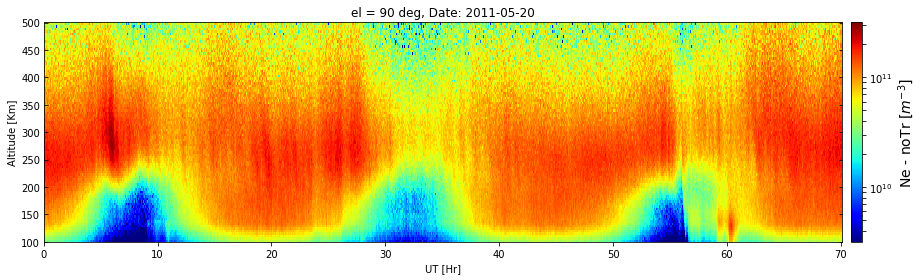

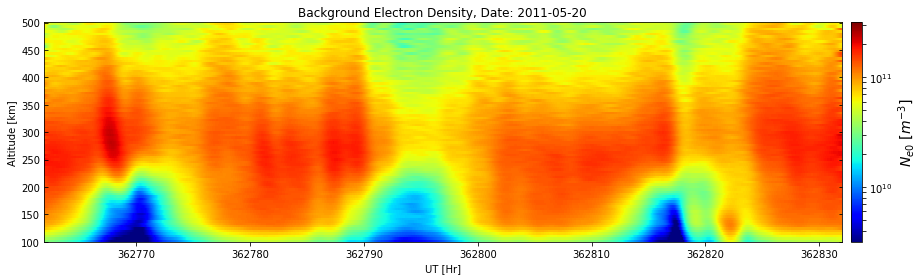

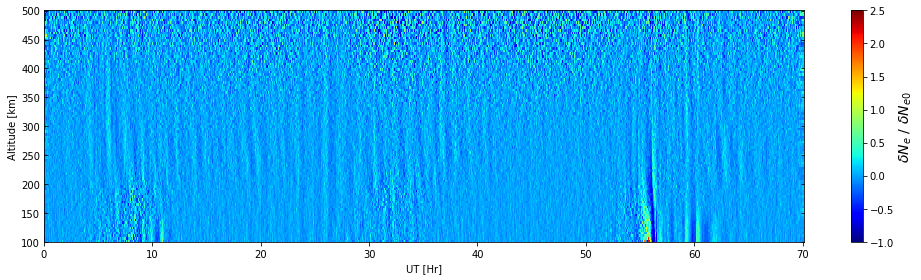

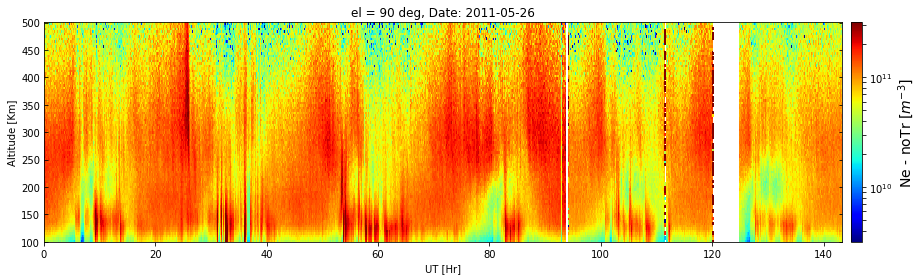

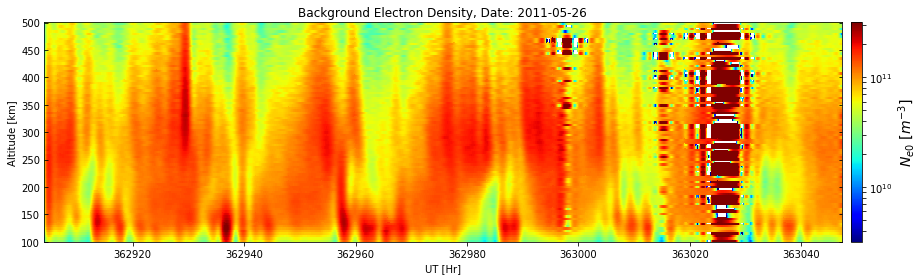

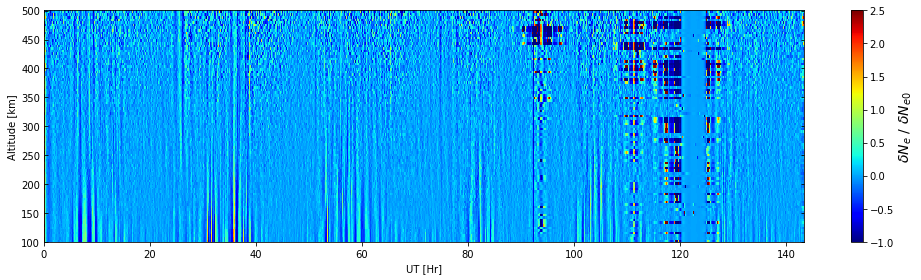

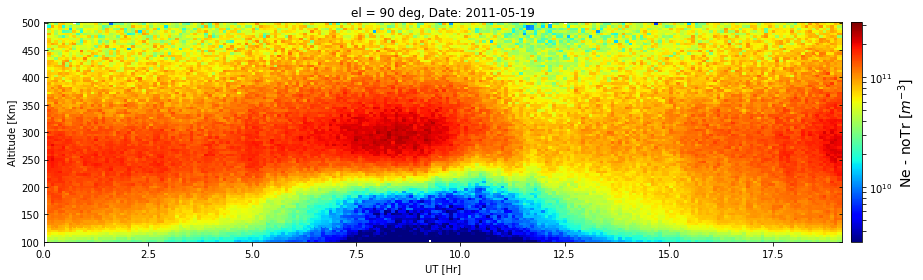

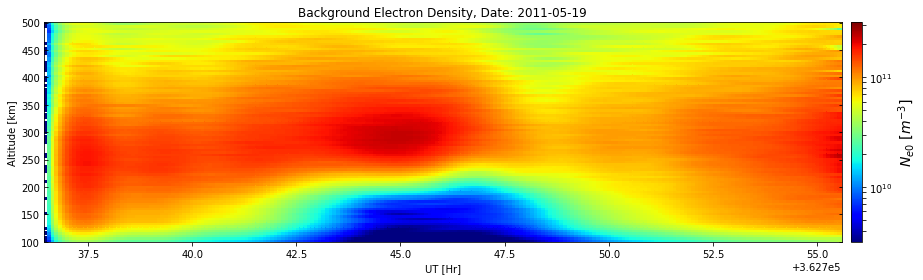

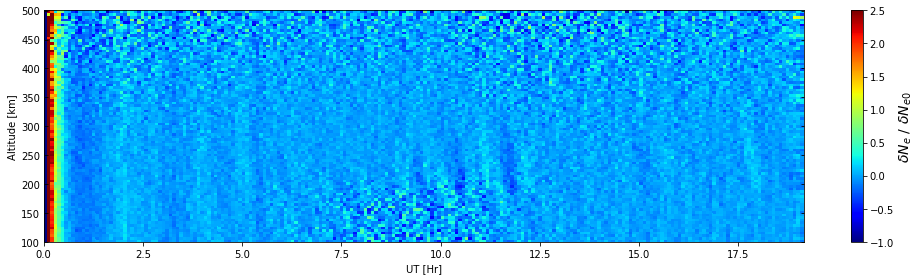

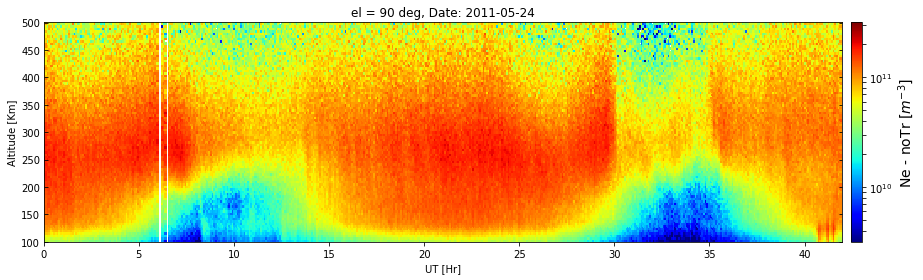

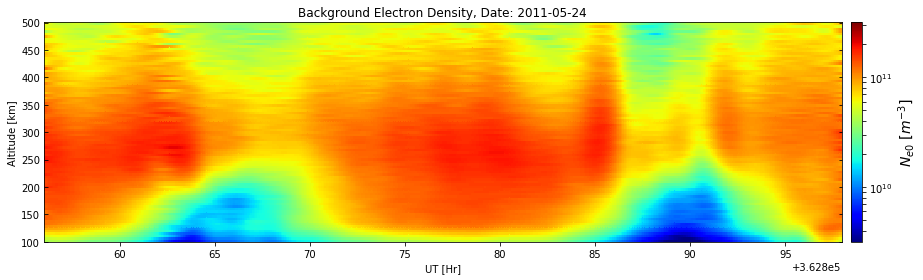

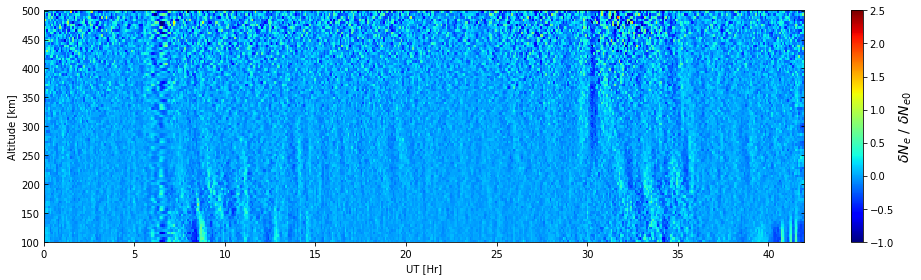

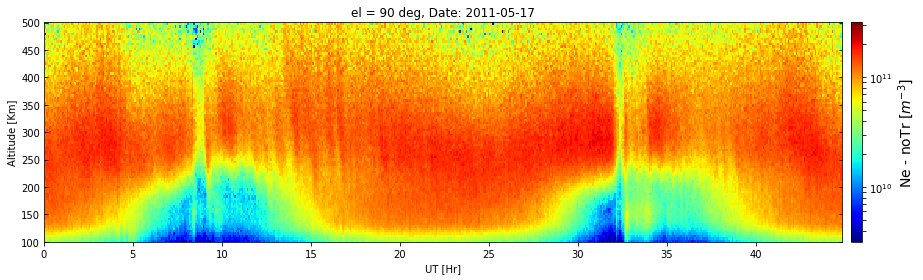

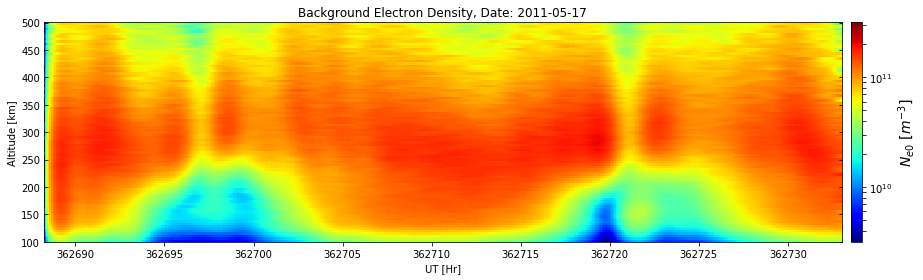

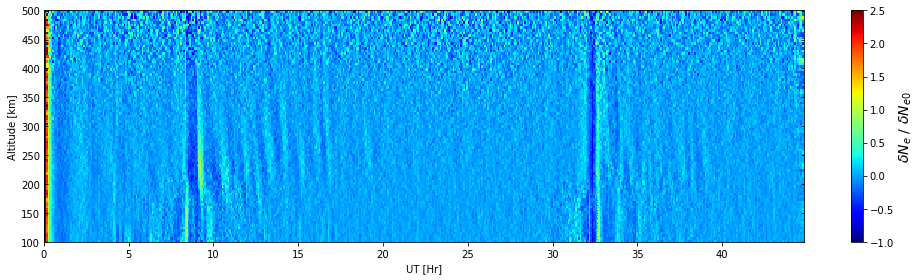

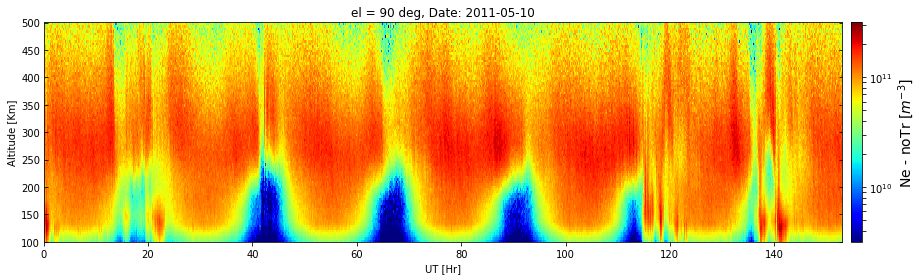

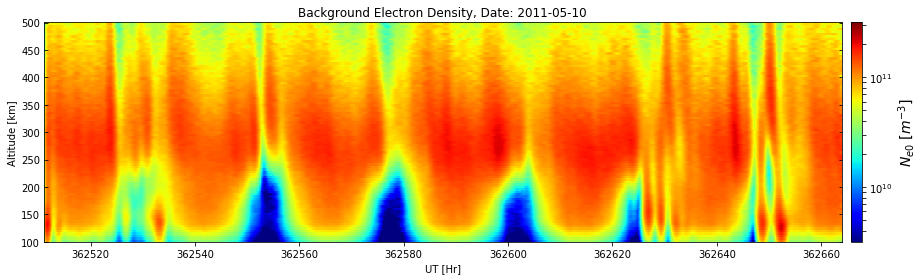

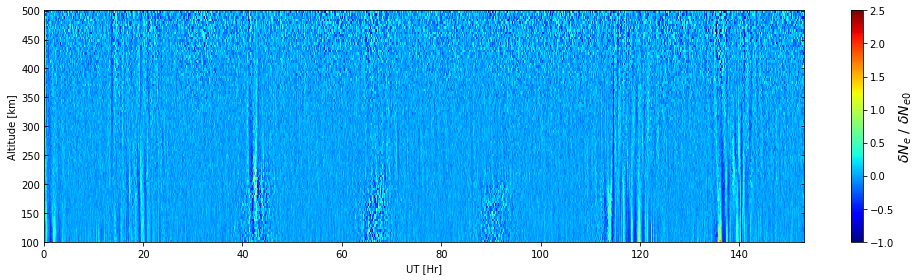

In [16]:
files = glob.glob('/Users/tedipro/Desktop/Atmos Research/ISR Data/*')

for i in range(len(files)):
    file_name = h5py.File(files[i],'r')
    e_density_data(file_name)
    background_e_density(file_name)
    relative_perturbations(file_name)
    #ls_spectrogram_data(file_name)
    #ls_periodogram_data(file_name)
    file_name.close()